In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from PIL import Image
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#df_train = pd.read_csv('/content/drive/MyDrive/APS360/train.csv')

#For Jessica's drive
df_train = pd.read_csv('/content/drive/MyDrive/APS360 Project/data/train.csv')

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.name = "ConvNet"
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels =3, out_channels = 5, kernel =5 
        self.pool = nn.MaxPool2d(2, 2) #kernel = 2, stride =2
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 53 * 53, 32) #need to calculate this dimension depending on input size
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]

        return x

In [ ]:
#Subject focus, group, blur, info, accesory
df_focus = df_train[["Id", "Subject Focus"]]
df_group = df_train[["Id", "Group"]]
df_blur = df_train[["Id", "Blur"]]
df_info = df_train[["Id", "Info"]]
df_accessory = df_train[["Id", "Accessory"]]

In [ ]:
CNN_Classifier = ConvNet();

In [10]:
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

train_set_focus = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/train_focus', transform=transform)
val_set_focus = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/val_focus', transform=transform)
test_set_focus = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/test_focus', transform=transform)

train_set_group = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/train_group', transform=transform)
val_set_group = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/val_group', transform=transform)
test_set_group = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/test_group', transform=transform)

train_set_blur = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/train_blur', transform=transform)
val_set_blur = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/val_blur', transform=transform)
test_set_blur = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/test_blur', transform=transform)

train_set_accessory = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/train_accessory', transform=transform)
val_set_accessory = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/val_accessory', transform=transform)
test_set_accessory = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/test_accessory', transform=transform)

train_set_info = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/train_info', transform=transform)
val_set_info = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/val_info', transform=transform)
test_set_info = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360 Project/data/meta_data/test_info', transform=transform)

In [12]:
def normalize_label(labels):
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train_net(train_set, val_set, net, batch_size=64, learning_rate=0.01, num_epochs=30, category = 'no_name'):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle = True)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    model_name = '/content/drive/MyDrive/APS360 Project/rec_models/'+ category + '_model_state.pth'
    torch.save(net.state_dict(), model_name)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [ ]:
CNN_Classifier_focus = ConvNet();
train_net(train_set_focus, val_set_focus, CNN_Classifier_focus, batch_size=64, learning_rate=0.01, num_epochs=10, category = 'focus')

Epoch 1: Train err: 0.5, Train loss: 0.6942228078842163 |Validation err: 0.5, Validation loss: 0.6919829249382019
Epoch 2: Train err: 0.5, Train loss: 0.6941705147425333 |Validation err: 0.5, Validation loss: 0.6975567638874054
Epoch 3: Train err: 0.5145985401459854, Train loss: 0.6932553582721286 |Validation err: 0.475, Validation loss: 0.6932225823402405
Epoch 4: Train err: 0.4981751824817518, Train loss: 0.692150526576572 |Validation err: 0.4625, Validation loss: 0.690874844789505
Epoch 5: Train err: 0.4835766423357664, Train loss: 0.6916001704004076 |Validation err: 0.2875, Validation loss: 0.6909330189228058
Epoch 6: Train err: 0.3357664233576642, Train loss: 0.6904791394869486 |Validation err: 0.3, Validation loss: 0.6885852217674255
Epoch 7: Train err: 0.3886861313868613, Train loss: 0.6900875700844659 |Validation err: 0.4875, Validation loss: 0.6892911791801453
Epoch 8: Train err: 0.3813868613138686, Train loss: 0.6880161166191101 |Validation err: 0.325, Validation loss: 0.6862

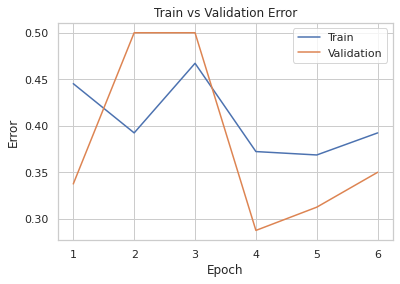

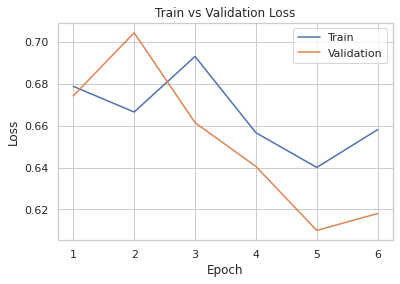

In [ ]:
plot_training_curve(get_model_name("ConvNet", batch_size=64, learning_rate=0.01, epoch=5))

In [ ]:
CNN_Classifier_group = ConvNet();
train_net(train_set_group, val_set_group, CNN_Classifier_group, batch_size=256, learning_rate=0.01, num_epochs=10, category = "group")

Epoch 1: Train err: 0.4781591263650546, Train loss: 0.6940950859676708 |Validation err: 0.5, Validation loss: 0.6936472058296204
Epoch 2: Train err: 0.4890795631825273, Train loss: 0.694733283736489 |Validation err: 0.4712041884816754, Validation loss: 0.6928480267524719
Epoch 3: Train err: 0.5058502340093604, Train loss: 0.6955273476513949 |Validation err: 0.450261780104712, Validation loss: 0.6918475925922394
Epoch 4: Train err: 0.5015600624024961, Train loss: 0.6915725036100908 |Validation err: 0.5, Validation loss: 0.6965913772583008
Epoch 5: Train err: 0.5, Train loss: 0.6925206888805736 |Validation err: 0.5, Validation loss: 0.6947554647922516
Epoch 6: Train err: 0.5, Train loss: 0.694881796836853 |Validation err: 0.5, Validation loss: 0.6960819363594055
Epoch 7: Train err: 0.5, Train loss: 0.6940876841545105 |Validation err: 0.5, Validation loss: 0.6935124099254608
Epoch 8: Train err: 0.5, Train loss: 0.6934909983114763 |Validation err: 0.5, Validation loss: 0.6930558383464813
E

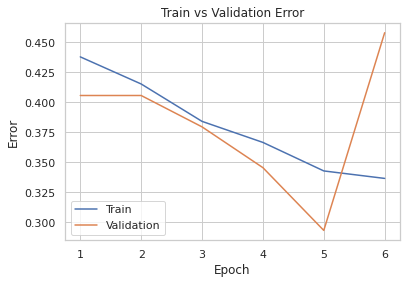

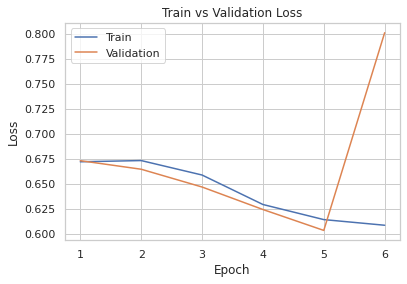

In [ ]:
plot_training_curve(get_model_name("ConvNet", batch_size=128, learning_rate=0.01, epoch=5))

Epoch 1: Train err: 0.45799011532125206, Train loss: 0.6917505389765689 |Validation err: 0.4444444444444444, Validation loss: 0.6854207515716553
Epoch 2: Train err: 0.45057660626029655, Train loss: 0.6832295656204224 |Validation err: 0.4222222222222222, Validation loss: 0.677083949247996
Epoch 3: Train err: 0.4308072487644152, Train loss: 0.6761888924397921 |Validation err: 0.4166666666666667, Validation loss: 0.6631901462872823
Epoch 4: Train err: 0.4942339373970346, Train loss: 0.6982324280236897 |Validation err: 0.5, Validation loss: 0.6903432210286459
Epoch 5: Train err: 0.4695222405271829, Train loss: 0.682533555909207 |Validation err: 0.40555555555555556, Validation loss: 0.6725170016288757
Epoch 6: Train err: 0.42751235584843494, Train loss: 0.6664410704060605 |Validation err: 0.39444444444444443, Validation loss: 0.6546950141588846
Finished Training
Total time elapsed: 710.62 seconds


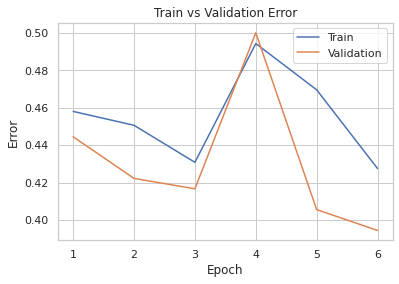

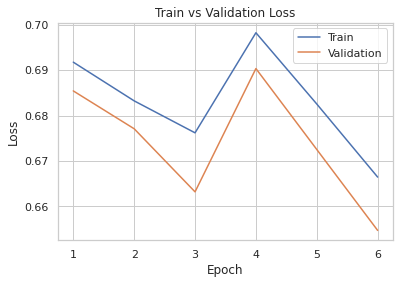

In [ ]:
CNN_Classifier_info = ConvNet();
train_net(train_set_info, val_set_info, CNN_Classifier_info, batch_size=64, learning_rate=0.01, num_epochs=6, category = "info")
plot_training_curve(get_model_name("ConvNet", batch_size=64, learning_rate=0.01, epoch=5))

In [ ]:
CNN_Classifier_blur = ConvNet();
train_net(train_set_blur, val_set_blur, CNN_Classifier_blur, batch_size=64, learning_rate=0.01, num_epochs=10, category = 'blur')
#plot_training_curve(get_model_name("ConvNet", batch_size=64, learning_rate=0.01, epoch=10))

Epoch 1: Train err: 0.5143266475644699, Train loss: 0.6961321912028573 |Validation err: 0.5, Validation loss: 0.6945400536060333
Epoch 2: Train err: 0.5, Train loss: 0.6937775070017035 |Validation err: 0.5, Validation loss: 0.6947606652975082
Epoch 3: Train err: 0.5, Train loss: 0.6933900551362471 |Validation err: 0.5, Validation loss: 0.6927423775196075
Epoch 4: Train err: 0.5171919770773639, Train loss: 0.6932669363238595 |Validation err: 0.5, Validation loss: 0.6931472718715668
Epoch 5: Train err: 0.502865329512894, Train loss: 0.693215096538717 |Validation err: 0.5, Validation loss: 0.6932423412799835
Epoch 6: Train err: 0.5, Train loss: 0.6931795830076392 |Validation err: 0.5, Validation loss: 0.6930613368749619
Epoch 7: Train err: 0.5, Train loss: 0.6931810487400402 |Validation err: 0.5, Validation loss: 0.6930426508188248
Epoch 8: Train err: 0.5157593123209169, Train loss: 0.6932451616634022 |Validation err: 0.5, Validation loss: 0.6931533366441727
Epoch 9: Train err: 0.51289398

In [ ]:
CNN_Classifier_accessory = ConvNet();
train_net(train_set_accessory, val_set_accessory, CNN_Classifier_accessory, batch_size=128, learning_rate=0.005, num_epochs=10, category= "accessory")


Epoch 1: Train err: 0.5007440476190477, Train loss: 0.6950706785375421 |Validation err: 0.485, Validation loss: 0.6944205164909363
Epoch 2: Train err: 0.5178571428571429, Train loss: 0.6954142071984031 |Validation err: 0.49, Validation loss: 0.6935161650180817
Epoch 3: Train err: 0.5014880952380952, Train loss: 0.6955872719938104 |Validation err: 0.5, Validation loss: 0.6931501626968384
Epoch 4: Train err: 0.5, Train loss: 0.6938168948346918 |Validation err: 0.5, Validation loss: 0.6941049098968506
Epoch 5: Train err: 0.5081845238095238, Train loss: 0.6939645409584045 |Validation err: 0.525, Validation loss: 0.6935200095176697
Epoch 6: Train err: 0.5238095238095238, Train loss: 0.6933716643940319 |Validation err: 0.525, Validation loss: 0.6933444142341614
Epoch 7: Train err: 0.5022321428571429, Train loss: 0.6928956508636475 |Validation err: 0.51, Validation loss: 0.6928646266460419
Epoch 8: Train err: 0.48735119047619047, Train loss: 0.6925881505012512 |Validation err: 0.51, Validatio

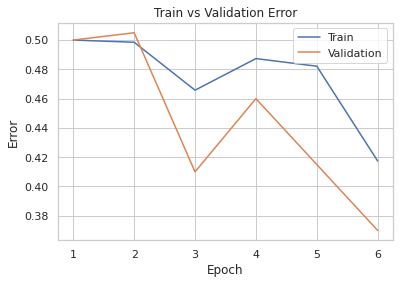

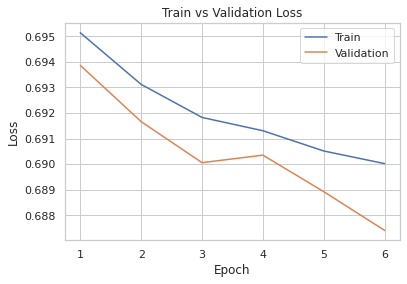

In [ ]:
plot_training_curve(get_model_name("ConvNet", batch_size=128, learning_rate=0.005, epoch=5))

In [ ]:
def print_test_img(label, df, test_set, index):
  df_one = df[df[label]==1]
  df_zero = df[df[label]==0]

  df_one.reset_index()
  df_zero.reset_index()
  length = min(len(df_one), len(df_zero))
  test_index = int(length*0.85)

  base_path = '/content/drive/MyDrive/APS360 Project/data/train/'
  
  fig = plt.figure(figsize=(20, 20))
  image_id = df.iloc[test_index + index][0]
  image_path = base_path + image_id + '.jpg'
  plt.imshow(Image.open(image_path))

In [ ]:
imsize = 224
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])((image))
    image = image.unsqueeze(0)
    return image



In [ ]:
def evaluate_demo(net, img_path):
  image = image_loader(img_path)
  outputs = net(image)
  if (outputs>0):
    pred = 1 
  else:
    pred = 0
  return pred

In [ ]:
#output recommendations:
def print_rec(label, pred):
  if pred ==0:
    print(" ", label)


In [ ]:
def demo_rec_model(img_path):
  print("Here are some suggestions to improve your image: \n")
  model_focus = ConvNet()
  model_path = '/content/drive/MyDrive/APS360 Project/rec_models/focus_model_state.pth'
  model_focus.load_state_dict(torch.load(model_path))
  pred_focus = evaluate_demo(model_focus, img_path)
  print_rec("Subject Focus", pred_focus)

  model_group = ConvNet()
  model_path = '/content/drive/MyDrive/APS360 Project/rec_models/group_model_state.pth'
  model_group.load_state_dict(torch.load(model_path))
  pred_group = evaluate_demo(model_group, img_path)
  print_rec("Grouping of animals", pred_group)

  model_blur = ConvNet()
  model_path = '/content/drive/MyDrive/APS360 Project/rec_models/blur_model_state.pth'
  model_blur.load_state_dict(torch.load(model_path))
  pred_blur = evaluate_demo(model_blur, img_path)
  print_rec("Blurry image", pred_blur)

  model_accessory = ConvNet()
  model_path = '/content/drive/MyDrive/APS360 Project/rec_models/accessory_model_state.pth'
  model_accessory.load_state_dict(torch.load(model_path))
  pred_accessory = evaluate_demo(model_accessory, img_path)
  print_rec("Add accessories", pred_accessory)

  model_info = ConvNet()
  model_path = '/content/drive/MyDrive/APS360 Project/rec_models/info_model_state.pth'
  model_info.load_state_dict(torch.load(model_path))
  pred_info = evaluate_demo(model_info, img_path)
  print_rec("Remove unnecessary", pred_info)


Here are some suggestions to improve your image: 

  Subject Focus
  Grouping of animals


In [ ]:
def demo_img(): 
  img_path = '/content/drive/MyDrive/APS360 Project/data/testing_imgs/IMG_20180117_181705.jpg'
  
  fig = plt.figure(figsize=(10, 10))
  plt.imshow(Image.open(img_path))  

In [ ]:
img_path = '/content/drive/MyDrive/APS360 Project/data/testing_imgs/IMG_20180117_181705.jpg'









# **DEMO**

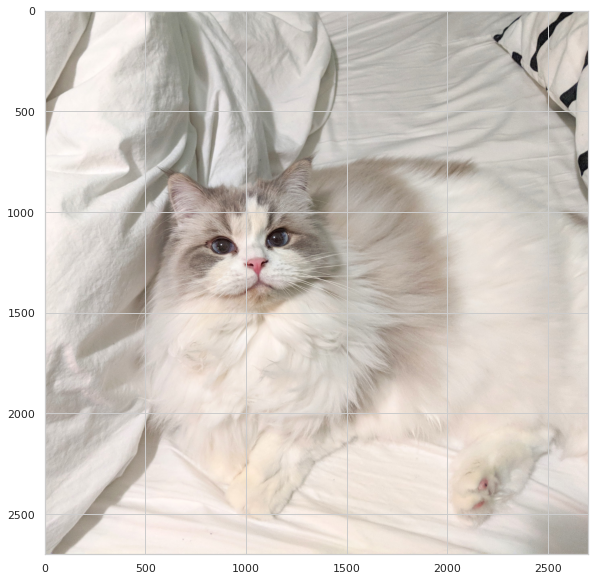

In [ ]:
demo_img()

In [ ]:
demo_rec_model (img_path)

Here are some suggestions to improve your image: 

  Subject Focus
  Grouping of animals
